In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Columns
- id - unique ID for excerpt
- url_legal - URL of source - this is blank in the test set.
- license - license of source material - this is blank in the test set.
- excerpt - text to predict reading ease of
- target - reading ease
- standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

### 仮説
- 文章のわかりにくさは何に起因するか？
- 長さ ⇔単語数、単語のユニーク数
- 難解な言葉 ⇔単語のレア度
- LSTMで文章ベクトル作成。学習データとする

In [23]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
display(train.head(3))
display(train.shape)

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676


(2834, 6)

In [111]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string


###英語の文章から特徴抽出をおこなう
class NLP_features():
    def __init__(self,seri):
        self.seri = seri
    ##単語数
    def countWords(self,x):
        val1 = len(x.replace('.',' .').split(' '))#単語数 
        return val1
    ##単語のユニーク数
    def countUniWords(self,x):
        val1 = len(set(x.replace('.',' .').split(' ')))#単語のユニーク数
        return val1
    ##文字数
    def countCharacters(self,x):
        val1 = len(x)##文字数
        return val1
    ##stopwordsの数を数える
    def countStopWords(self,x):
        val1 = len([elt for elt in str(x).lower().split() if elt in nltk.corpus.stopwords.words("english")])
        return val1
    ##単語の平均の長さ
    def meanWordsLength(self,x):
        words = pd.Series(x.replace('.',' .').split(' '))
        val1 = np.mean(words.apply(lambda x: len(x)))        
        return val1
    #句読点の数
    def punctuationCount(self,x):
        val1 = len([elt for elt in str(x) if elt in string.punctuation])
        return val1
    
    def extractMain(self):
        out_df = pd.DataFrame([])
        out_df['words_count'] = self.seri.apply(lambda x: self.countWords(x))
        out_df['unique_words_count'] = self.seri.apply(lambda x: self.countUniWords(x))
        out_df['characters_count'] = self.seri.apply(lambda x: self.countCharacters(x))
        out_df['stop_words_count'] = self.seri.apply(lambda x: self.countStopWords(x))
        out_df['mean_words_length'] = self.seri.apply(lambda x: self.meanWordsLength(x))
        out_df['punctuation_count'] = self.seri.apply(lambda x: self.punctuationCount(x))
        return out_df

In [112]:
ins = NLP_features(seri=train['excerpt'])
x2 = ins.extractMain()

In [125]:

x2['target'] = train['target']
x2["target_bins"] = pd.cut(train["target"].values,[train["target"].min()-1,train["target"].quantile(0.25),\
                                                    train["target"].quantile(0.5),train["target"].quantile(0.75),train["target"].quantile(1)],right=True,labels=[f"Q{i}" for i in range(1,5)])

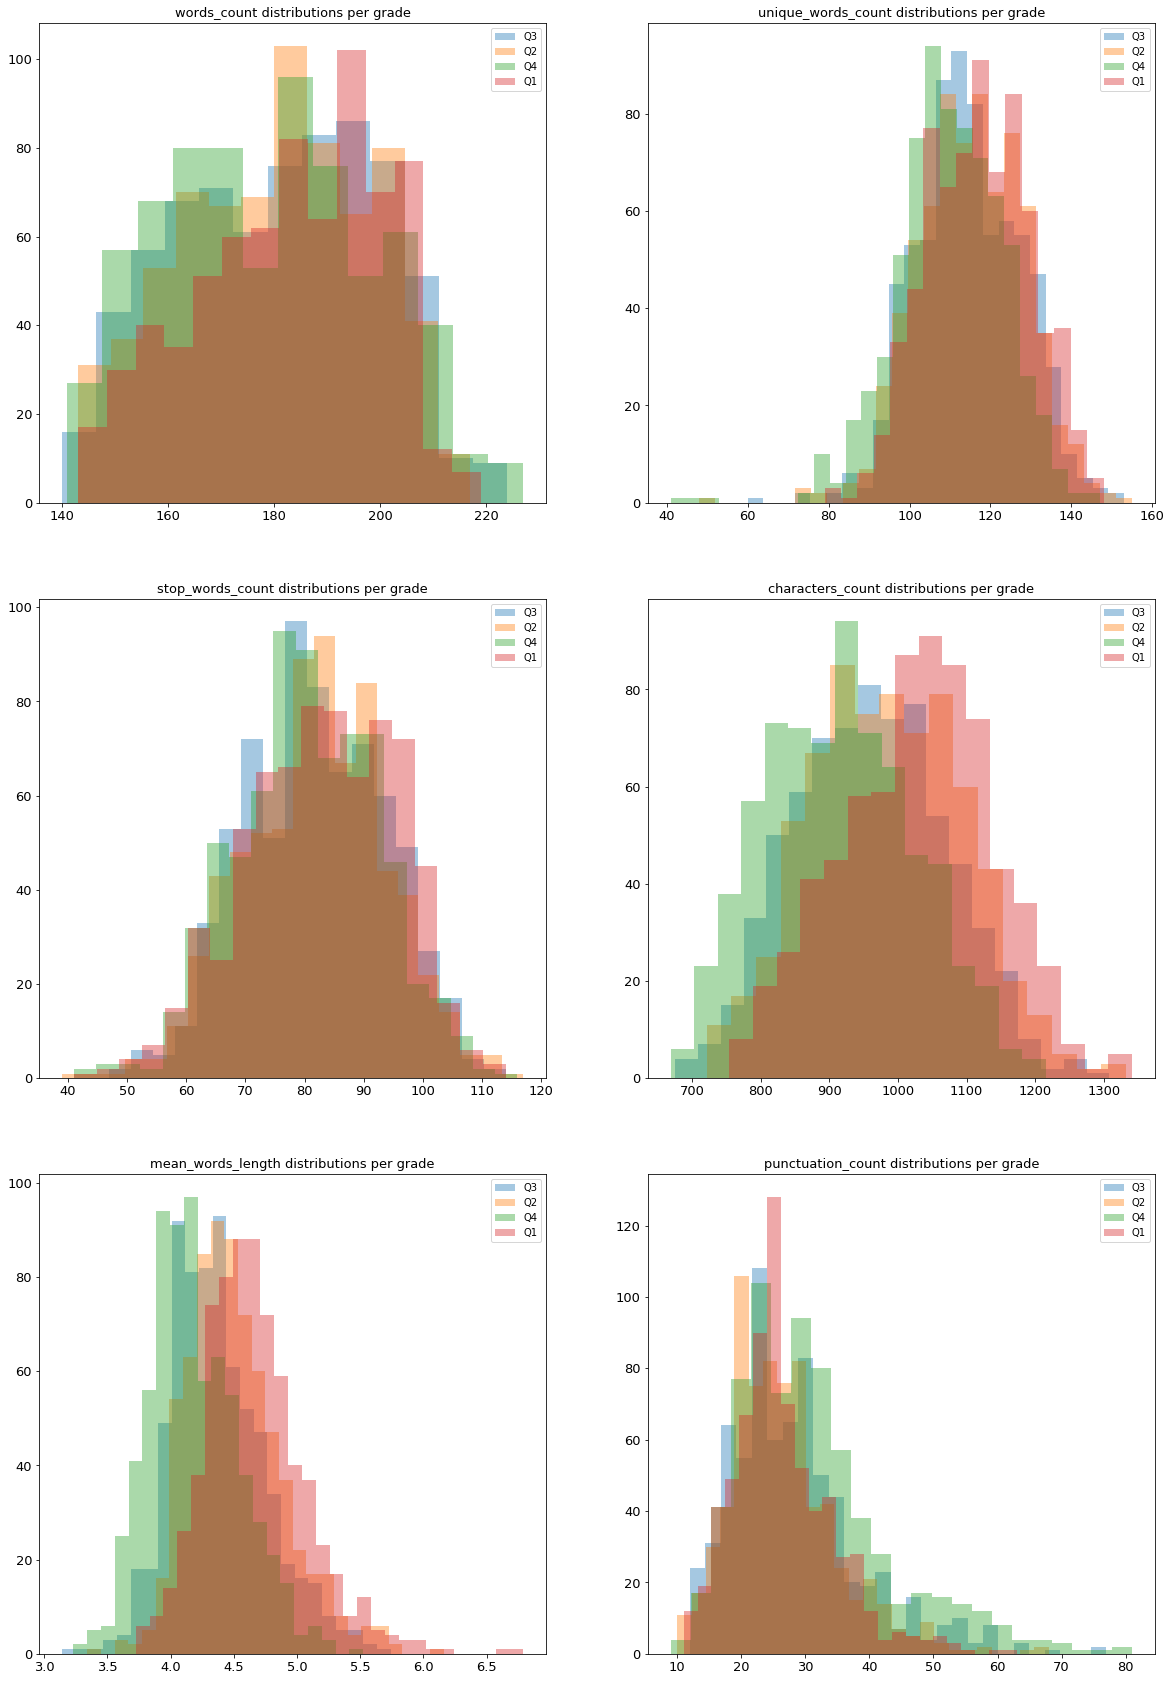

In [118]:
##Q1:難解,Q4:平易
meta_features = ["words_count","unique_words_count","stop_words_count","characters_count",\
                "mean_words_length","punctuation_count"]
target_bins = x2["target_bins"].unique()
fig, ax = plt.subplots(3,2,figsize=(20,30))
for i,meta in enumerate(meta_features) :
    for grade in target_bins :
        mask = x2["target_bins"]== grade
        sns.distplot(x2[mask][meta],ax=ax[i//2,i%2],label=grade,kde=False)
        ax[i//2,i%2].set_title(f"{meta} distributions per grade",fontsize=13)
        ax[i//2,i%2].set_xlabel(" ")
        ax[i//2,i%2].tick_params(axis="x",labelsize=13)
        ax[i//2,i%2].tick_params(axis="y",labelsize=13)
        ax[i//2,i%2].legend()
plt.show()

Text(0.5, 1, 'Correlation of Meta features with target')

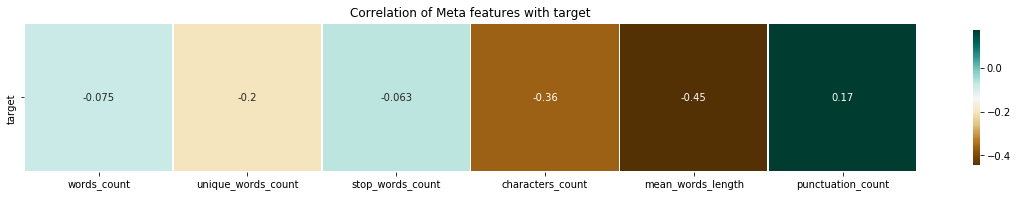

In [126]:
# Investigate correlation between meta features and the target fature.
fig = plt.figure(figsize=(20,5))
correlation = pd.DataFrame({feature: x2["target"].corr(x2[feature]) for feature in \
                           meta_features},index=["target"])
sns.heatmap(correlation,annot=True,square=True,cmap='BrBG',linewidths=0.5,\
            cbar_kws={"shrink": .5})
plt.title("Correlation of Meta features with target")